In [1]:
import shutil

import matplotlib.pyplot as plt
import pandas as pd

import evalml

from functions import *

pd.set_option('display.float_format', '{:.6f}'.format)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
2023-10-29 18:47:56.682466: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-29 18:47:57.701489: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Data

In [2]:
max_zeros_pct = 0.3
window_size = 3
sequence_length = 10

df = load_and_merge()
df = remove_underpopulated_taxa(df, max_zeros_pct)
df = standard_rolling_average(df, window_size)
df = feature_wise_scaling(df)

In [3]:
df

,364179,189384,865469,585419,564806,309391,682726,3154070,553611,262095,...,193484,577170,359650,193233,196664,583117,354850,subject_id,sampling_day,ind_time
E000823.4.0,0.000160,0.100671,0.002424,0.000379,0.113394,0.000000,0.149880,0.000327,0.018368,0.034098,...,0.000000,0.122840,0.000000,0.040201,0.059699,0.010154,0.064039,E000823,0.072046,0.072046
E000823.5.0,0.000160,0.120805,0.000958,0.000632,0.117647,0.000000,0.161871,0.000491,0.015911,0.038716,...,0.000000,0.155183,0.000000,0.035804,0.054162,0.010779,0.029557,E000823,0.100865,0.100865
E000823.5.7,0.000180,0.053691,0.000620,0.058665,0.089668,0.000000,0.203837,0.000981,0.016023,0.081743,...,0.000000,0.115150,0.000000,0.034338,0.060045,0.009685,0.019704,E000823,0.121037,0.121037
E000823.6.7,0.000160,0.080537,0.159159,0.135397,0.062047,0.053140,0.206235,0.000654,0.012226,0.098214,...,0.038943,0.071113,0.000000,0.021566,0.035127,0.006092,0.000000,E000823,0.149856,0.149856
E000823.8.5,0.000220,0.053691,0.158651,0.136450,0.046781,0.053140,0.197842,0.007195,0.010887,0.093596,...,0.038943,0.083439,0.000000,0.050251,0.061602,0.037334,0.000000,E000823,0.201729,0.201729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E014086.30.4,0.080890,0.503356,0.038563,0.005180,0.008506,0.015700,0.308153,0.007032,0.000056,0.024708,...,0.012517,0.288137,0.536697,0.091290,0.127531,0.423113,0.068966,E014086,0.832853,0.832853
E014086.32.4,0.120524,0.711409,0.077127,0.006233,0.005103,0.028986,0.130695,0.011284,0.000000,0.014778,...,0.033380,0.426464,0.653670,0.142169,0.345042,0.622876,0.285714,E014086,0.890490,0.890490
E014086.33.5,0.141802,0.906040,0.098213,0.005728,0.005238,0.033816,0.116307,0.021913,0.000000,0.011469,...,0.043115,0.507480,0.597477,0.213358,0.537809,0.756436,0.507389,E014086,0.922190,0.922190
E014086.34.4,0.127490,0.899329,0.063201,0.001558,0.003760,0.032609,0.049161,0.028618,0.000000,0.006542,...,0.040334,0.571745,0.582569,0.241625,0.631597,0.749125,0.610837,E014086,0.948127,0.948127


## Features and targets

In [70]:
def xgboost_flat_feats_and_targets(df, n_test_seq, seq_length, validation_pct=0.1):
    
    subjects = df.subject_id.unique()
    df_subject_grp = df.groupby("subject_id")
    
    test_subjects_idx = np.random.choice(len(subjects), size=n_test_seq, replace=False)
    test_subjects = subjects[test_subjects_idx]
    
    print(f"The test subjects are {test_subjects}")
    
    train_feats = []
    train_targets = []
    test_feats = {test_subject: [] for test_subject in test_subjects}
    test_targets = {test_subject: [] for test_subject in test_subjects}
    
    for subject_id in subjects:
        subject_df = df_subject_grp.get_group(subject_id).drop(columns=["subject_id"])
        subject_feats, subject_targets = create_flat_sequences(subject_df, seq_length=seq_length)
    
        if subject_id in test_subjects:
            test_feats[subject_id] = subject_feats
            test_targets[subject_id] = subject_targets
        else:
            train_feats.append(subject_feats)
            train_targets.append(subject_targets)
            
    train_feats = pd.concat(train_feats).reset_index(drop=True)
    train_targets = pd.concat(train_targets).reset_index(drop=True)
    
    
    # get the validation sets
    validation_size = int(np.round(validation_pct * len(train_feats)))
    validation_idxs = list(np.random.choice(range(len(train_feats)), size=validation_size, replace=False))
    
    val_feats = train_feats.loc[validation_idxs]
    val_targets = train_targets.loc[validation_idxs]
    
    train_feats = train_feats.drop(validation_idxs)
    train_targets = train_targets.drop(validation_idxs)
    
    return train_feats, train_targets, val_feats, val_targets, test_feats, test_targets, test_subjects

In [71]:
number_test_sequences = 3
sequence_length = 10

train_feats, train_targets, val_feats, val_targets, test_feats, test_targets, test_subjects = xgboost_flat_feats_and_targets(df, n_test_seq=number_test_sequences, seq_length=sequence_length)

The test subjects are ['E013094' 'E000823' 'E012854']


In order to properly train an XGBoost model we need a proper validation set

## The model

In [75]:
import xgboost as xgb
model = xgb.XGBRegressor(objective='reg:squarederror', 
                         n_estimators=10, 
                         max_leaves=100,
                         max_depth=100,  
                         n_jobs=50)

In [76]:
model.fit(train_feats, train_targets, eval_set=[(val_feats, val_targets)], verbose=True)

[0]	validation_0-rmse:0.11996
[1]	validation_0-rmse:0.10291
[2]	validation_0-rmse:0.09347
[3]	validation_0-rmse:0.08833
[4]	validation_0-rmse:0.08635
[5]	validation_0-rmse:0.08529
[6]	validation_0-rmse:0.08523
[7]	validation_0-rmse:0.08534
[8]	validation_0-rmse:0.08557
[9]	validation_0-rmse:0.08570


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=100, max_leaves=100,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=50,
             num_parallel_tree=None, random_state=None, ...)

## Validation

In [77]:
test_subjects

array(['E013094', 'E000823', 'E012854'], dtype=object)

In [78]:
target_subject_idx = 0
target_subject = test_subjects[target_subject_idx]

subject_feats = test_feats[target_subject]
subject_targets = test_targets[target_subject]

In [80]:
subject_targets

,364179,189384,865469,585419,564806,309391,682726,3154070,553611,262095,...,4357811,1059729,997439,193484,577170,359650,193233,196664,583117,354850
10,0.026042,0.140940,0.241811,0.162813,0.016385,0.157005,0.164269,0.104170,0.032883,0.080049,...,0.107527,0.079470,0.032486,0.347705,0.099874,0.504587,0.320561,0.145527,0.203418,0.669951
11,0.000681,0.114094,0.260811,0.160792,0.016519,0.307971,0.116307,0.172363,0.023895,0.080434,...,0.086022,0.086093,0.032486,0.443672,0.178045,0.537844,0.570352,0.247102,0.253655,0.566502
12,0.000661,0.046980,0.194452,0.014319,0.010744,0.240338,0.039568,0.150777,0.000056,0.077124,...,0.064516,0.043046,0.027189,0.296245,0.147809,0.338303,0.520310,0.214224,0.180549,0.349754
13,0.000500,0.006711,0.047359,0.002443,0.001880,0.205314,0.001199,0.131480,0.000000,0.004387,...,0.037634,0.013245,0.004237,0.122392,0.139170,0.077982,0.372069,0.147949,0.070670,0.349754
14,0.000280,0.006711,0.024525,0.017351,0.007566,0.091787,0.019185,0.095830,0.000558,0.001770,...,0.026882,0.000000,0.010946,0.057024,0.108302,0.110092,0.409338,0.133068,0.100662,0.236453
15,0.000280,0.006711,0.158990,0.021226,0.009401,0.073671,0.035971,0.089616,0.003796,0.004233,...,0.016129,0.000000,0.014124,0.054242,0.129056,0.143349,0.471524,0.165946,0.124406,0.330049
16,0.000841,0.006711,0.182895,0.021478,0.010923,0.123188,0.053957,0.105151,0.004131,0.004849,...,0.048387,0.006623,0.016243,0.091794,0.146755,0.182339,0.605946,0.244160,0.178487,0.325123
17,0.002262,0.020134,0.303152,0.010107,0.007610,0.099034,0.039568,0.105642,0.003573,0.008621,...,0.080645,0.006623,0.011653,0.072323,0.124947,0.178899,0.445771,0.215262,0.156867,0.330049
18,0.007647,0.067114,0.422619,0.008423,0.019160,0.324879,0.041966,0.158299,0.000614,0.026478,...,0.172043,0.043046,0.015890,0.264256,0.121892,0.284404,0.635260,0.307320,0.287616,0.369458
19,0.014673,0.067114,0.424818,0.010529,0.021175,0.316425,0.028777,0.150286,0.000335,0.033944,...,0.166667,0.036424,0.015537,0.264256,0.103139,0.267202,0.602806,0.278595,0.298550,0.344828


In [83]:
pred_df = pd.DataFrame(model.predict(subject_feats))
pred_df.columns = subject_targets.columns
pred_df

,364179,189384,865469,585419,564806,309391,682726,3154070,553611,262095,...,4357811,1059729,997439,193484,577170,359650,193233,196664,583117,354850
0,0.067401,0.153221,0.083014,0.112476,0.011126,0.119002,0.053312,0.102019,0.018056,0.018011,...,0.134825,0.050830,0.010631,0.208306,0.123019,0.287696,0.131333,0.102619,0.089662,0.525957
1,0.063426,0.128668,0.201035,0.125863,0.018472,0.095170,0.189295,0.163813,0.018056,0.067636,...,0.151273,0.076252,0.040326,0.198156,0.089036,0.388933,0.263766,0.108457,0.165617,0.469554
2,0.007770,0.143514,0.197399,0.109715,0.016518,0.279254,0.050999,0.176991,0.018056,0.074709,...,0.113708,0.074893,0.048043,0.617067,0.158586,0.392621,0.293673,0.075024,0.196217,0.466764
3,0.007770,0.124384,0.070410,0.015228,0.020161,0.265794,0.047891,0.171573,0.004948,0.049469,...,0.122368,0.038717,0.037145,0.178274,0.160199,0.279880,0.205444,0.139667,0.237555,0.267256
4,0.007770,0.087166,0.031084,0.006862,0.009261,0.179192,0.016390,0.172074,0.004948,0.020565,...,0.035472,0.037701,0.007551,0.209949,0.134308,0.235246,0.208118,0.161754,0.090233,0.308272
5,0.004570,0.031102,0.031188,0.030833,0.011505,0.079541,0.017367,0.159924,0.004948,0.015359,...,0.079566,0.028647,0.008078,0.059973,0.129702,0.127195,0.223930,0.176181,0.122237,0.261132
6,0.007220,0.023314,0.093274,0.031737,0.015007,0.057186,0.052852,0.185716,0.008372,0.014251,...,0.063943,0.033583,0.012474,0.053424,0.163818,0.151056,0.223930,0.124618,0.127248,0.200984
7,0.007220,0.017744,0.101344,0.030664,0.015981,0.091819,0.050196,0.191638,0.008372,0.014212,...,0.052175,0.033583,0.027924,0.198049,0.152409,0.147474,0.248299,0.196286,0.203020,0.195880
8,0.007714,0.162385,0.181688,0.013895,0.009382,0.101036,0.047433,0.190858,0.008372,0.014212,...,0.121079,0.030113,0.012496,0.052827,0.141871,0.245357,0.266881,0.189545,0.192197,0.270953
9,0.010448,0.183201,0.221008,0.013895,0.019257,0.336780,0.052609,0.167924,0.004948,0.040177,...,0.221958,0.080686,0.014871,0.254497,0.163539,0.261897,0.298119,0.377319,0.244205,0.288626


In [84]:
errors_df = calculate_percentage_errors(pred_df, subject_targets)
errors_df.describe()

,364179,189384,865469,585419,564806,309391,682726,3154070,553611,262095,...,4357811,1059729,997439,193484,577170,359650,193233,196664,583117,354850
count,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,...,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000
mean,12.469422,94239725.562345,2.071996,2.138481,1.109085,2.577773,3.188014,0.589469,7068227.749084,4.690347,...,1.833813,47391752.599770,1.516822,1.398345,0.544434,1.577378,0.528217,0.381025,0.484939,0.638837
std,24.287872,352612752.556097,5.769127,2.865129,2.505012,7.985936,10.297809,0.802814,17967027.746000,9.038492,...,2.501401,121769413.648964,2.340836,2.178100,0.990153,3.097843,0.105291,0.239154,0.752647,1.149339
min,0.000846,0.077309,0.015156,0.217233,0.032086,0.064329,0.020484,0.020653,0.244341,0.031313,...,0.253868,0.114299,0.042836,0.036928,0.005009,0.019854,0.387999,0.055981,0.013533,0.162986
25%,0.497356,0.229308,0.481502,0.375195,0.223899,0.150240,0.134112,0.131487,1.105753,0.481035,...,0.324052,0.514240,0.238563,0.418992,0.154303,0.163312,0.444200,0.221156,0.074437,0.220168
50%,2.166159,1.892249,0.596235,0.627102,0.347409,0.415177,0.403049,0.330935,11.355699,1.288867,...,0.600420,0.734476,0.550422,0.676732,0.235942,0.289540,0.515271,0.368797,0.234553,0.319143
75%,13.586188,3.344132,0.768877,2.279212,0.743119,0.706012,0.679077,0.779958,39.619241,2.460205,...,2.433272,3.534046,1.239033,1.275268,0.554188,1.816809,0.587698,0.543212,0.343249,0.413346
max,92.192593,1319356113.672256,22.099833,9.313917,9.722629,30.297214,38.941422,3.165170,49477373.249829,33.651063,...,9.145188,377014279.365540,7.766149,8.556800,3.915787,11.814802,0.785710,0.799888,2.361472,4.593190


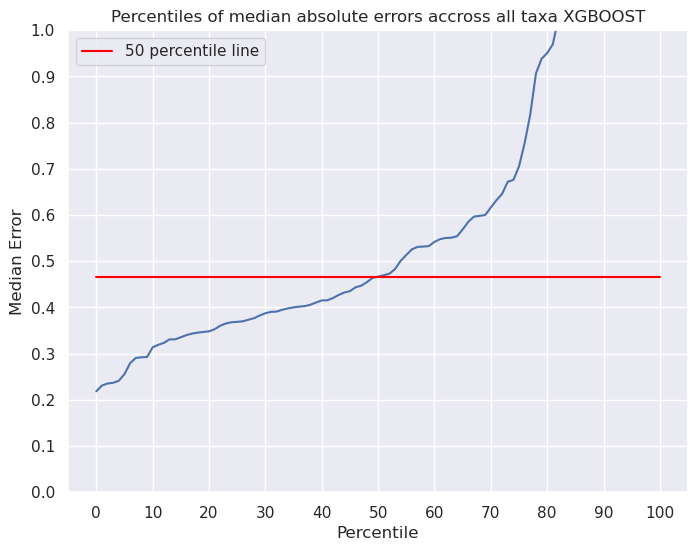

In [85]:
percentile_graph(errors_df, "accross all taxa XGBOOST", y_top_lim=1)